In [2]:
using MAT, Statistics, LinearAlgebra,Random, Plots, NonlinearSolve
using StaticArrays, ForwardDiff, Distributed, StaticArrays, SciMLNLSolve, SimpleNonlinearSolve, LineSearches, NLsolve
include("mvnrnd.jl")

mvnrnd (generic function with 1 method)

In [3]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    if size(v,2) == 1 # check if v is a column vector
        @eval (($s) = (vec($v)))
    else
        @eval (($s) = ($v))
    end
end

file = matopen("simulationData.mat")

#Reads in ju[IO, price, Omega, data, labor, mu, aggtfp, alpha, grossy, stfp, beta, agggdp, Sigma, capital, vadd]

varnames = names(file)
for varname in varnames
    val = read(file, varname)
    # Instantiate the variable with its name in the current scope
    string_as_varname(varname,val)
    end

close(file)



In [4]:
function getVariables(year)
    IO = data[data[:,1] .== year,:]
    temp = [8,60,62,80:88...]
    IO = IO[setdiff(1:end,temp),setdiff(1:end,[1,2,3,4,5,94])]
    IO = IO[:,setdiff(1:end,temp)]
    Ω = IO ./ sum(IO,dims=2)
    α = vadd[:,year-1959] ./ grossy[:,year-1959];
    β = (grossy[:,year-1959]' * (I-diagm(1 .- α)*Ω))';
    β[beta .< 0] .= 0
    β = β / sum(β)
    λ = (inv(I - diagm(1 .- alpha)*Ω)' * β);
    L = λ .* α
    
    return α,β,Ω,L,λ

end

getVariables (generic function with 1 method)

In [5]:
domar_weights = (inv(I - diagm(1 .- alpha) * Omega)' * beta);
L = domar_weights .* alpha;

In [6]:
ε = .5;
θ = 0.001;
σ = .9;

In [7]:
function problem(X :: AbstractVector{T}, A, β, Ω, α, ε, θ, σ,L) where T



    N = length(α)
    p = X[1:N]
    y = X[N+1:end]
    
    Out :: Vector{T} = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    Out[1:N] = p - (A .^ (ε - 1) .* (α .* w .^ (1- ε) + (1 .- α) .* q .^ (1 - ε))) .^ (1/(1-ε))
    Out[N+1:end] = y' - y' * diagm(p)^ε * diagm(A)^(ε-1) * diagm(q)^(θ-ε) * diagm(1 .- α) * Ω * diagm(p)^(-θ) - β'*diagm(p)^(-σ)*C
    
    return Out
end

problem (generic function with 1 method)

In [8]:
function problemJacobian(X, A, β, Ω, α, ε, θ, σ,L)
    N = length(α)
    p = @view X[1:N]
    y = @view X[N+1:end]
    
    Out = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    
    DQDP = (q .^ θ * (p.^(-θ))') .* Ω;
    DWDP = diagm(A.^((ε-1)/ε) .* α.^(1/ε) .* y.^(1/ε) .* (1 ./ L).^(1/ε));
    DWDY = (1/ε) * diagm(p .* A.^((ε-1)/ε) .* α.^(1/ε).* (y.^(1/ε-1)) .* L.^(-1/ε));
    DCDP = DWDP' * L; 
    DCDY = DWDY' * L;

    DOut1DP = I - diagm(diagm(A)^(-1) * ((α .* (w .^ (1-ε)) + (1 .- α) .* (q.^(1-ε)))).^(ε/(1-ε))) * (diagm(α) * diagm(w.^(-ε))* DWDP + diagm(1 .-α)*diagm(q.^(-ε))*DQDP);

    DOut1DY =  -diagm(diagm(A.^(-1))*((α.*(w.^(1-ε))+(1 .- α).*(q.^(1-ε)))).^(ε/(1-ε)))*(diagm(α)*diagm(w.^(-ε))*DWDY);

    DOut2DP = -(ε * diagm(p.^(-θ))*Ω'*diagm((p.^(ε-1)).*(y).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))
        + (θ-ε)*diagm(p.^(-θ))*Ω'*diagm((p.^(ε)).*(y).*(q.^(θ-ε-1)).*(1 .- α).*(A.^(ε-1)))*DQDP 
        - σ*diagm(β.*p.^(-σ-1))*C + broadcast(*, β.*(p.^(-σ)), DCDP')
        - θ* diagm(p.^(-θ-1)).*diagm(Ω'*diagm((p.^(ε)).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))*y));

    DOut2DY = I - (diagm(p)^ε*diagm(A)^(ε-1)*diagm(q)^(θ-ε)*diagm(1 .- α)*Ω*diagm(p)^(-θ))' - broadcast(*, β.*(p.^(-σ)), DCDY');
    OutDeriv = [DOut1DP DOut1DY; DOut2DP DOut2DY];

end

problemJacobian (generic function with 1 method)

In [27]:
trials = 50;
GDP = zeros(trials)
λ = zeros(76,trials)

function f!(F,u,p)
    F[1:152] = problem(u,p,beta,Omega,alpha,ε,θ,σ,L)
end

function j!(J,u,p)
    J[1:152,1:152] = problemJacobian(u,p,beta,Omega,alpha,ε,θ,σ,L)
end

f = NonlinearFunction(f!)

Threads.@threads for k in 1:trials
    
        
    A = exp.(mvnrnd(-1/2*diag(Sigma),diagm(diag(Sigma))));
    
    #init = [Complex.(exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A)))..., Complex.(domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A)))...];
    
    init = [exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A))..., (domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A)))...]


    p = A

    ProbN = NonlinearProblem(f,init,p)
    sol = solve(ProbN,NLSolveJL(linesearch = HagerZhang(),method = :newton), reltol = 1e-8,abstol = 1e-8)

    x = sol.u
    println("solv")

    GDP[k] = (x[1:76] .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(x[77:152].^(1/ε)).* L .^ (-1/ε))' * L;
    λ[:,k] = (x[1:76] .* x[77:end]) / GDP[k] 


        
end

DomainError: DomainError with -14.677858914341611:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [11]:
function shockSectorProgressively(sector,shocks,x0,year = 1983)

    (α,β,Ω,L,λ) = getVariables(year);
    f = NonlinearFunction((u,p) -> problem(u,p...))
    GDP = []
    for shock in shocks
        A  = ones(76)
        A[sector] = shock
        
        
    
    
        p = [A,β,Ω,α,ε,θ,σ,L]
        ProbN = NonlinearProblem(f,x0,p)
        
        sol = solve(ProbN,NLSolveJL(linesearch = BackTracking(),method = :newton), reltol = 1e-8,abstol = 1e-8)
        
        x = sol.u
        
        p = real.(x[1:76]) 
        y = real.(x[77:152])
        append!(GDP, (p .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(y.^(1/ε)).* L .^ (-1/ε))' * L)

        x0 =  x
    end

    return GDP

end

shockSectorProgressively (generic function with 2 methods)

In [15]:
year = 1975
M = 20

a = 0.7;
b = 1.3;

(α,β,Ω,L,λ) = getVariables(year);


GDP = zeros(2*M,3)
sectors = [7 8 53]
sectorShocks = [LinRange(1,a,M)..., LinRange(1,b,M)...]


@distributed for i in 1:length(sectors)
    
    x0 = Complex.([ones(76)...,λ...]);

    GDP[1:M,i] = shockSectorProgressively(sectors[i],LinRange(1,a,M),x0,year)
    GDP[M+1:end,i] =  shockSectorProgressively(sectors[i],LinRange(1,b,M),x0,year)

    
end


In [13]:

@views reverse!(GDP[1:M,:],dims=1)
GDP = GDP[setdiff(1:end,M),:]

19×3 Matrix{Float64}:
 1.00084   0.948292  0.97064
 0.99738   0.955527  0.974946
 0.99405   0.962412  0.979038
 0.991139  0.968982  0.982938
 0.98831   0.975262  0.986661
 0.992643  0.981279  0.990223
 0.996179  0.987053  0.993637
 0.998906  0.992604  0.996914
 1.00117   0.997948  1.00007
 1.0031    1.0031    1.0031
 1.00478   1.00807   1.00603
 1.00625   1.01288   1.00885
 1.00756   1.01753   1.01158
 1.00872   1.02204   1.01422
 1.00976   1.02641   1.01678
 1.0107    1.03065   1.01926
 1.01155   1.03477   1.02167
 1.01232   1.03878   1.024
 1.01301   1.04267   1.02628

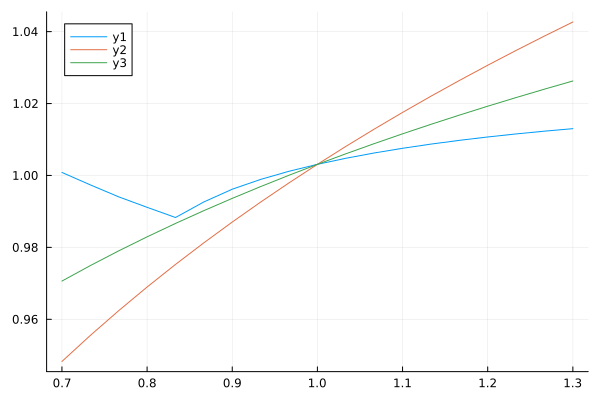

In [14]:
plot(LinRange(a,b,2*M-1),GDP[:,1])
plot!(LinRange(a,b,2*M-1),GDP[:,2])
plot!(LinRange(a,b,2*M-1),GDP[:,3])

In [1]:
Threads.nthreads()

8

In [23]:
@views reverse!(GDP[1:M-2,:],dims=1)

8×3 view(::Matrix{Float64}, 1:8, :) with eltype Float64:
 0.966997  0.96083   0.996753
 0.97552   0.967623  0.996333
 0.98162   0.974269  0.996328
 0.987477  0.980736  0.997077
 0.992308  0.986659  0.999837
 0.996392  0.993301  0.998019
 1.00455   1.00531   1.00736
 1.00931   1.00931   1.00931